In [2]:
import sys
sys.path.insert(0, 'G://My Drive//Current Projects//Angstrom Method//Angstrom-method')
# save blmcmc.py into the path specified in the directory above.

from blmcmc import temperature_preprocessing_extract_phase_amplitude, Metropolis_Hasting_sampler,least_square_regression_Angstrom, post_processing_results, multi_chain_Metropolis_Hasting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
directory_path = "C://Users//YuanYuan//Desktop//Amgstrom_method//" 

"""
# This is the directory of the project, within this project, please create three folders with these names:

1. temperature data
2. time data
3. phase amplitude data

In the first folder, please create Folders where you save temperature csv files. For example, you have a IR video recording named
IR_recording_X, then first you should create a folder under 'temperature data' called 'IR_recording_X'. Then you should
export IR images from the IR video as csv files under this naming conventions, IR_recording_X_i.csv, where i indicate ith 
IR image.

In the second folder, you need to indicate the time sequence that corresponds to the temperature csv files. In Filr software,
Just create any region of interest and create a complete temporal plot, output this temporal plot as a csv file and name it under
this convention: IR_recording_X_time.csv, then place this csv file into 'time data' folder.


The third folder save processed temperature measurement results and obtain phase and amplitude within the region of analysis on the sample

"""
file_name = 'Rec-000833' # The format of the file name, for instance, IR image as csv files in IR video should be saved as Rec-000833_0.csv,...Rec-000833_j.csv,...Rec-000833_N.csv
f_heating = 0.4 #periodic heating frequency



x_heater = 100; y_heater = 165 # put the coordinate of center of the interface of the heater here. 
x_region_line_center = 314 ; y_region_line_center = 185 # for the region of analysis, find the edge which is closest to the heater, write down the center of this edge here 
dx = 100 ; dy = 50 ; gap = 5 ; px = 25/10**6 # dx, dy indicate the width of the region of analysis, gap indicates the distance of evenly space isothermal lines within the region of analysis, px indicate real distance to pixel convertion, it means how long a pixel is in meter.
direction = 'up-bottom' ; analysis_method = 'sine' #'right-left', 'fft'

"""
Here we define a region of analysis for the IR video, in which Angstrom method is applied.
1. First we find the interface of the heater, and then find it's center and put the x and y coordinates in the code above (x_heater, y_heater).
2. Next we draw a rectangle to indicate our region of analysis. We find the edge of the region which is closest to the heater,
then we put the center of this edge (x_region_line_center,y_region_line_center) into the code above
3. The you need to specify the width and length of this region of analysis, dx indicate the width in x direction, and dy indicate the width in y direction
4. We calculate amplitude ratio from two evenly spaced isothermal lines, gap (in pixels) indicate the distance between these neighboring isothermal lines.
5. px indicates the distance of a pixel in meters, for close up lens used in this study, px = 25 um.
6. direction indicates the direction of heat propagate, possible values are 'up-bottom' , 'bottom-up','left-right', 'right-left'
7. analysis_method indicates how we determine phase and amplitude from temperature measurements, we can either fit the temperature profiles using sinusoidal function, or use fast fourier transform, 
both approaches yields very similar results. use 'sine' or 'fft' here.
"""

# This section of code basically put input variables as dictionary to load into the program
time_stamp = pd.read_csv(directory_path+'time data//'+file_name+"_time"+'.csv')
analysis_region = {'f_heating':f_heating,'x_heater':x_heater,'y_heater':y_heater,'x_region_line_center':x_region_line_center,'y_region_line_center':y_region_line_center,
                  'dx':dx,'dy':dy,'gap':gap,'px':px, 'direction':direction,'analysis_method':analysis_method,
                   'directory_path':directory_path, 'file_path': directory_path+"temperature data//"+file_name+"//",'file_name':file_name}


# create an instance of class 'temperature_preprocessing_extract_phase_amplitude' to use for temperature processing
phase_amp_processor = temperature_preprocessing_extract_phase_amplitude(analysis_region,time_stamp)
T_rec833 = phase_amp_processor.load_temperature_profiles() # take 3mins

"""
Loads the IR image (csv files) as a 3D array, first two dimentions are temperature at x,y locations for an IR image, the third dimension indicates image frame
The reason to output this variable is because everytime load csv files into memory takes 3mins, if there are multiple region 
need to be analyzed for one IR video, I don't want to load them everytime. If you need to analyze another region for the same
IR video, you should create another instance of 'temperature_preprocessing_extract_phase_amplitude', for exmaple phase_amp_processor_1,
then because T_rec833 is already saved in memory, you don't have to load it again using phase_amp_processor.load_temperature_profiles().
Instead, do this:

phase_amp_processor_1 = temperature_preprocessing_extract_phase_amplitude(analysis_region,time_stamp)
phase_amp_processor_1.temp_full = T_rec833

and use phase_amp_processor_1 onwards.

This add temperauture profile to the new instance
"""

df_amplitude_phase = phase_amp_processor.batch_process_horizontal_lines() 
phase_amp_processor.save_phase_amplitude_to_csv(df_amplitude_phase)

"""""
How after loading temperature profiles into the instance, we use batch_process_horizontal_lines function to calculate amplitude ratio and phase differences,
using: 
df_amplitude_phase = phase_amp_processor.batch_process_horizontal_lines() 
Then we save the results using:
phase_amp_processor.save_phase_amplitude_to_csv(df_amplitude_phase)
The saved csv file is in the folder 'phase amplitude data', such that we can load again in the future should we need to rerun this code,
when you do that, use the code below:

phase_amp_processor = temperature_preprocessing_extract_phase_amplitude(analysis_region,time_stamp)
phase_amp_processor.load_phase_ampltude_csv()

You don't have to reprocessing temperature measurements again.
"""""

Optimization terminated successfully.
         Current function value: 0.020117
         Iterations: 99
         Function evaluations: 212
 final_simplex: (array([[ -5.11561669, -12.47419393],
       [ -5.11561669, -12.47422898],
       [ -5.11561669, -12.47425151]]), array([0.02011728, 0.02011728, 0.02011728]))
           fun: 0.02011727523475003
       message: 'Optimization terminated successfully.'
          nfev: 212
           nit: 99
        status: 0
       success: True
             x: array([ -5.11561669, -12.47419393])


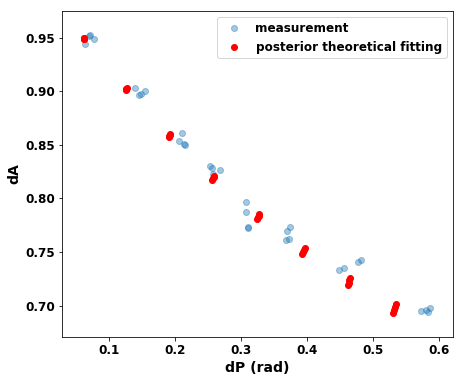

In [10]:
material_properties = {'L':3.76e-3,'r':4e-3,'cp':693,'rho':3120} # 
"""
Here you need to specify the properties of the material:
L: the length of sample in the direction of heat propagation, pay attention, it's the length in the direction of heat propagation
r: radius if the crossection area is circle, a*b/(a+b) if crossection is rectangle. Note that crossection is perpendicular to the direction of heat propagation.
cp: specific heat of the material. unit in J/kg.K
rho: density of the material. unit kg/m3
"""

param_init = [-5,1] #log(alpha), #log(h)
Angstrom_regression = least_square_regression_Angstrom(param_init, analysis_region,df_amplitude_phase, material_properties)
result = Angstrom_regression.minimize_regression('phase-amplitude') #'phase'
print(result)
Angstrom_regression.show_fitting_results() # this code print fitting of the model to experimental data

In [ ]:
# final_simplex: (array([[ -5.11561669, -12.47419393], the first element is log10(alpha), the second element is log10(h),
# here alpha = 10**(-5.115616), and h = 10**(-12.4741)
# 